# Feature Engineering & Importance Testing
Goal of this notebook is to get an overview of all the features found around different kernels in this competition, as well as add a few new ones, and test their importance for predicting is_attributed using xgBoost. 

## Current best score with these features
Current I've got a public LB score of **0.9769** using V2 of these features, and the xgBoost parameters found by [Bayesian Optimization in this notebook](https://www.kaggle.com/nanomathias/bayesian-tuning-of-xgboost-lightgbm-lb-0-9769), training on the entire dataset.

## Inspirational Notebooks
Inspiration for features from (let me know if I have forgotten to give credit to anyone)
* https://www.kaggle.com/nuhsikander/lgbm-new-features-corrected
* https://www.kaggle.com/rteja1113/lightgbm-with-count-features
* https://www.kaggle.com/aharless/swetha-s-xgboost-revised
* https://www.kaggle.com/bk0000/non-blending-lightgbm-model-lb-0-977


# 1. Loading data
I'll just load a small subset of the data for more speedy testing

In [1]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Load subset of the training data
X_train = pd.read_csv('/Users/mlx/Downloads/Document/talking_data/train_2m.csv', parse_dates=['click_time'])

# Show the head of the table
X_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,123896,25,1,25,259,2017-11-07 13:32:55,NaN,0
1,38732,2,1,22,237,2017-11-07 02:57:07,NaN,0
2,135586,3,1,19,280,2017-11-07 03:14:46,NaN,0
3,189070,3,1,13,173,2017-11-09 10:48:37,NaN,0
4,89669,1,1,19,135,2017-11-09 08:02:33,NaN,0


In [17]:
X_test = pd.read_csv('/Users/mlx/Downloads/Document/talking_data/test.csv', parse_dates=['click_time'])

## 1.1 Top 20 by IP, Device, OS, App, Channel: attributed vs non-attributed

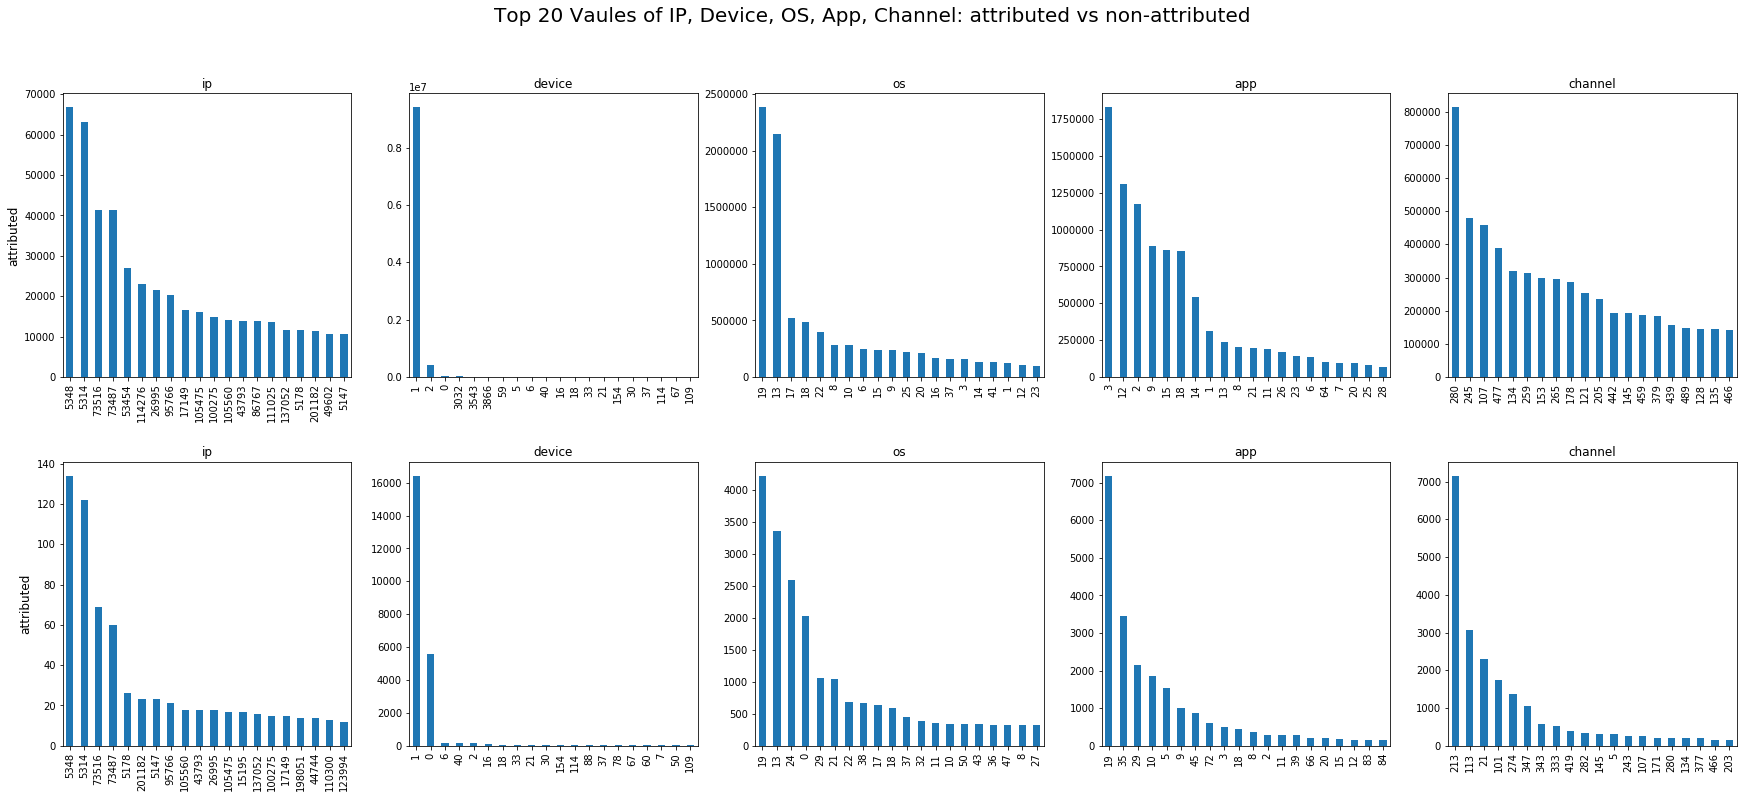

In [35]:
fig, axes = plt.subplots(2, 5)
fig.set_figheight(12)
fig.set_figwidth(30)
fig.suptitle('Top 20 Vaules of IP, Device, OS, App, Channel: attributed vs non-attributed', fontsize=20)
labels = [0, 1]
attributes = ['ip', 'device', 'os', 'app', 'channel']
for label in labels:
    for idx, attr in enumerate(attributes):
        values = X_train[X_train.is_attributed == label][attr].value_counts().head(20)
        ax = values.plot.bar(ax=axes[label][idx])
        ax.set_title(attr)
        if idx == 0:
            if attributed == 0:
                h = ax.set_ylabel('not-attributed', rotation='vertical', size='large')
            else:
                h= ax.set_ylabel('attributed', rotation='vertical', size='large')
plt.subplots_adjust(hspace=0.3)
plt.show()
fig.savefig('basic_features_distribution.png', dpi=150)

# 2. Creating Features
## 2.1 Extracting time information
First extract day, minute, hour, second from the click_time. 

In [2]:
X_train['day'] = X_train['click_time'].dt.day.astype('uint8')
X_train['hour'] = X_train['click_time'].dt.hour.astype('uint8')
X_train['minute'] = X_train['click_time'].dt.minute.astype('uint8')
X_train['second'] = X_train['click_time'].dt.second.astype('uint8')
X_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second
0,123896,25,1,25,259,2017-11-07 13:32:55,NaN,0,7,13,32,55
1,38732,2,1,22,237,2017-11-07 02:57:07,NaN,0,7,2,57,7
2,135586,3,1,19,280,2017-11-07 03:14:46,NaN,0,7,3,14,46
3,189070,3,1,13,173,2017-11-09 10:48:37,NaN,0,9,10,48,37
4,89669,1,1,19,135,2017-11-09 08:02:33,NaN,0,9,8,2,33


In [18]:
X_test['day'] = X_test['click_time'].dt.day.astype('uint8')
X_test['hour'] = X_test['click_time'].dt.hour.astype('uint8')
X_test['minute'] = X_test['click_time'].dt.minute.astype('uint8')
X_test['second'] = X_test['click_time'].dt.second.astype('uint8')

## 2.2. Confidence Rates for is_attributed
My thought is that some ips, apps, devices, etc. might have higher frequencies of is_attributed, and I wish to add that information, i.e. I'm calculating the following "attributed rates":

\begin{equation}
\text{P}\,\text{(is_attributed}\,\,|\,\,\text{category)}
\end{equation}

or in some cases two- or multiple-paired combinations:

\begin{equation}
\text{P}\,\text{(is_attributed}\,\,|\,\,\text{category_1, category_2)}
\end{equation}

The danger of this is that if a given category-combination has very few clicks, then the statistical significance of above equations cannot be trusted. Therefore I'll be weighing the rates by the following confidence rates:

\begin{equation}
    \text{conf}_{\text{is_attributed}} = \frac{\log(\text{views}_{\text{category_1}})}{\log(100000)}
\end{equation}

where the value 100000 has been chosen arbitrarily to such that if a given category has 1000 views, then it gets a confidence weight of 60%, if it has 100 views then onfly a confidence weight of 40% etc.

In [3]:
ATTRIBUTION_CATEGORIES = [        
    # V1 Features #
    ###############
    ['ip'], ['app'], ['device'], ['os'], ['channel'],
    
    # V2 Features #
    ###############
    ['app', 'channel'],
    ['app', 'os'],
    ['app', 'device'],
    
    # V3 Features #
    ###############
    ['channel', 'os'],
    ['channel', 'device'],
    ['os', 'device']
]


# Find frequency of is_attributed for each unique value in column
freqs = {}
for cols in ATTRIBUTION_CATEGORIES:
    
    # New feature name
    new_feature = '_'.join(cols)+'_confRate'    
    
    # Perform the groupby
    group_object = X_train.groupby(cols)
    
    # Group sizes    
    group_sizes = group_object.size()
    log_group = np.log(100000) # 1000 views -> 60% confidence, 100 views -> 40% confidence 
    print(">> Calculating confidence-weighted rate for: {}.\n   Saving to: {}. Group Max /Mean / Median / Min: {} / {} / {} / {}".format(
        cols, new_feature, 
        group_sizes.max(), 
        np.round(group_sizes.mean(), 2),
        np.round(group_sizes.median(), 2),
        group_sizes.min()
    ))
    
    # Aggregation function
    def rate_calculation(x):
        """Calculate the attributed rate. Scale by confidence"""
        rate = x.sum() / float(x.count())
        conf = np.min([1, np.log(x.count()) / log_group])
        return rate * conf
    
    # Perform the merge
    X_train = X_train.merge(
        group_object['is_attributed']. \
            apply(rate_calculation). \
            reset_index(). \
            rename( 
                index=str,
                columns={'is_attributed': new_feature}
            )[cols + [new_feature]],
        on=cols, how='left'
    )
    
X_train.head()

>> Calculating confidence-weighted rate for: ['ip'].
   Saving to: ip_confRate. Group Max /Mean / Median / Min: 13468 / 20.24 / 5.0 / 1
>> Calculating confidence-weighted rate for: ['app'].
   Saving to: app_confRate. Group Max /Mean / Median / Min: 366789 / 6349.21 / 13.0 / 1
>> Calculating confidence-weighted rate for: ['device'].
   Saving to: device_confRate. Group Max /Mean / Median / Min: 1885889 / 3236.25 / 1.0 / 1
>> Calculating confidence-weighted rate for: ['os'].
   Saving to: os_confRate. Group Max /Mean / Median / Min: 477170 / 8547.01 / 20.5 / 1
>> Calculating confidence-weighted rate for: ['channel'].
   Saving to: channel_confRate. Group Max /Mean / Median / Min: 162418 / 11494.25 / 2754.5 / 1
>> Calculating confidence-weighted rate for: ['app', 'channel'].
   Saving to: app_channel_confRate. Group Max /Mean / Median / Min: 156258 / 2732.24 / 30.5 / 1
>> Calculating confidence-weighted rate for: ['app', 'os'].
   Saving to: app_os_confRate. Group Max /Mean / Median / Mi

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,...,app_confRate,device_confRate,os_confRate,channel_confRate,app_channel_confRate,app_os_confRate,app_device_confRate,channel_os_confRate,channel_device_confRate,os_device_confRate
0,123896,25,1,25,259,2017-11-07 13:32:55,NaN,0,7,13,...,0.000000,0.001793,0.001038,0.000336,0.000000,0.000000,0.000000,0.000893,0.000373,0.001055
1,38732,2,1,22,237,2017-11-07 02:57:07,NaN,0,7,2,...,0.000257,0.001793,0.001751,0.000281,0.000281,0.000641,0.000269,0.000486,0.000290,0.001800
2,135586,3,1,19,280,2017-11-07 03:14:46,NaN,0,7,3,...,0.000286,0.001793,0.001817,0.000289,0.000237,0.000290,0.000294,0.000336,0.000300,0.001846
3,189070,3,1,13,173,2017-11-09 10:48:37,NaN,0,9,10,...,0.000286,0.001793,0.001519,0.000658,0.000282,0.000265,0.000294,0.001491,0.000660,0.001560
4,89669,1,1,19,135,2017-11-09 08:02:33,NaN,0,9,8,...,0.000153,0.001793,0.001817,0.000124,0.000303,0.000164,0.000161,0.000324,0.000126,0.001846


In [19]:
for cols in ATTRIBUTION_CATEGORIES:
    new_feature = '_'.join(cols)+'_confRate'
    
    def rate_calculation(x):
        """Calculate the attributed rate. Scale by confidence"""
        rate = x.sum() / float(x.count())
        conf = np.min([1, np.log(x.count()) / log_group])
        return rate * conf
    
    X_test = X_test.merge(
        X_train.groupby(cols)['is_attributed']. \
        apply(rate_calculation). \
        reset_index(). \
        rename( 
            index=str,
            columns={'is_attributed': new_feature}

        )[cols + [new_feature]],
        on=cols, how='left'
    )

Locally I computed 10-fold cross-validation scores with 10million samples using xgBoost to see how each feature improved the model or not. The result was as follows:
    
<img src='http://i66.tinypic.com/120h01w.png' alt="Local Frequency CV tests" width='50%'/>

On the public LB the score was improved from **0.955 -> 0.9624** by just including these features

## 2.3. Group-By-Aggregation
There are a lot of groupby -> count()/var()/mean() etc. feature engineering in the kernels I've checked out, so of course those have to be added as well :)

In [4]:
# Define all the groupby transformations
GROUPBY_AGGREGATIONS = [
    
    # V1 - GroupBy Features #
    #########################    
    # Variance in day, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'day', 'agg': 'var'},
    # Variance in hour, for ip-app-os
    {'groupby': ['ip','app','os'], 'select': 'hour', 'agg': 'var'},
    # Variance in hour, for ip-day-channel
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'},
    # Count, for ip-day-hour
    {'groupby': ['ip','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app
    {'groupby': ['ip', 'app'], 'select': 'channel', 'agg': 'count'},        
    # Count, for ip-app-os
    {'groupby': ['ip', 'app', 'os'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app-day-hour
    {'groupby': ['ip','app','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Mean hour, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'hour', 'agg': 'mean'}, 
    
    # How popular is the app or channel?
    {'groupby': ['app'], 'select': 'channel', 'agg': 'count'},
    {'groupby': ['channel'], 'select': 'app', 'agg': 'count'},
    
    # V3 - GroupBy Features                                              #
    # https://www.kaggle.com/bk0000/non-blending-lightgbm-model-lb-0-977 #
    ###################################################################### 
    {'groupby': ['ip'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','day'], 'select': 'hour', 'agg': 'nunique'}, 
    {'groupby': ['ip','app'], 'select': 'os', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'device', 'agg': 'nunique'}, 
    {'groupby': ['app'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip', 'device', 'os'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','device','os'], 'select': 'app', 'agg': 'cumcount'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'cumcount'}, 
    {'groupby': ['ip'], 'select': 'os', 'agg': 'cumcount'},    
]

# Apply all the groupby transformations
for spec in GROUPBY_AGGREGATIONS:
    
    # Name of the aggregation we're applying
    agg_name = spec['agg_name'] if 'agg_name' in spec else spec['agg']
    
    # Name of new feature
    new_feature = '{}-{}-{}'.format('_'.join(spec['groupby']), agg_name, spec['select'])
    
    # Info
    print("Grouping by {}, and aggregating {} with {}".format(
        spec['groupby'], spec['select'], agg_name
    ))
    
    # Unique list of features to select
    all_features = list(set(spec['groupby'] + [spec['select']]))
    
    # Perform the groupby
    gp = X_train[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature})
        
    # Merge back to X_total
    if 'cumcount' == spec['agg']:
        X_train[new_feature] = gp[0].values
    else:
        X_train = X_train.merge(gp, on=spec['groupby'], how='left')
        
     # Clear memory
    del gp
    gc.collect()

X_train.head()

Grouping by ['ip', 'app', 'channel'], and aggregating day with var
Grouping by ['ip', 'app', 'os'], and aggregating hour with var
Grouping by ['ip', 'day', 'channel'], and aggregating hour with var
Grouping by ['ip', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app'], and aggregating channel with count
Grouping by ['ip', 'app', 'os'], and aggregating channel with count
Grouping by ['ip', 'app', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app', 'channel'], and aggregating hour with mean
Grouping by ['app'], and aggregating channel with count
Grouping by ['channel'], and aggregating app with count
Grouping by ['ip'], and aggregating channel with nunique
Grouping by ['ip'], and aggregating app with nunique
Grouping by ['ip', 'day'], and aggregating hour with nunique
Grouping by ['ip', 'app'], and aggregating os with nunique
Grouping by ['ip'], and aggregating device with nunique
Grouping by ['app'], and aggregating channel with nunique


,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,...,ip-nunique-channel,ip-nunique-app,ip_day-nunique-hour,ip_app-nunique-os,ip-nunique-device,app-nunique-channel,ip_device_os-nunique-app,ip_device_os-cumcount-app,ip-cumcount-app,ip-cumcount-os
0,123896,25,1,25,259,2017-11-07 13:32:55,NaN,0,7,13,...,65,24,14,2,1,1,3,0,0,0
1,38732,2,1,22,237,2017-11-07 02:57:07,NaN,0,7,2,...,61,18,15,8,1,22,9,0,0,0
2,135586,3,1,19,280,2017-11-07 03:14:46,NaN,0,7,3,...,6,5,6,3,1,38,2,0,0,0
3,189070,3,1,13,173,2017-11-09 10:48:37,NaN,0,9,10,...,42,17,14,8,2,38,10,0,0,0
4,89669,1,1,19,135,2017-11-09 08:02:33,NaN,0,9,8,...,46,18,13,1,3,28,13,0,0,0


In [22]:
# Define all the groupby transformations
GROUPBY_AGGREGATIONS = [
    
    # V1 - GroupBy Features #
    #########################    
    # Variance in day, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'day', 'agg': 'var'},
    # Variance in hour, for ip-app-os
    {'groupby': ['ip','app','os'], 'select': 'hour', 'agg': 'var'},
    # Variance in hour, for ip-day-channel
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'},
    # Count, for ip-day-hour
    {'groupby': ['ip','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app
    {'groupby': ['ip', 'app'], 'select': 'channel', 'agg': 'count'},        
    # Count, for ip-app-os
    {'groupby': ['ip', 'app', 'os'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app-day-hour
    {'groupby': ['ip','app','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Mean hour, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'hour', 'agg': 'mean'}, 
    
    # How popular is the app or channel?
    {'groupby': ['app'], 'select': 'channel', 'agg': 'count'},
    {'groupby': ['channel'], 'select': 'app', 'agg': 'count'},
    
    # V3 - GroupBy Features                                              #
    # https://www.kaggle.com/bk0000/non-blending-lightgbm-model-lb-0-977 #
    ###################################################################### 
    {'groupby': ['ip'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','day'], 'select': 'hour', 'agg': 'nunique'}, 
    {'groupby': ['ip','app'], 'select': 'os', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'device', 'agg': 'nunique'}, 
    {'groupby': ['app'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip', 'device', 'os'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','device','os'], 'select': 'app', 'agg': 'cumcount'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'cumcount'}, 
    {'groupby': ['ip'], 'select': 'os', 'agg': 'cumcount'},    
]

# Apply all the groupby transformations
for spec in GROUPBY_AGGREGATIONS:
    
    # Name of the aggregation we're applying
    agg_name = spec['agg_name'] if 'agg_name' in spec else spec['agg']
    
    # Name of new feature
    new_feature = '{}-{}-{}'.format('_'.join(spec['groupby']), agg_name, spec['select'])
    
    # Info
    print("Grouping by {}, and aggregating {} with {}".format(
        spec['groupby'], spec['select'], agg_name
    ))
    
    # Unique list of features to select
    all_features = list(set(spec['groupby'] + [spec['select']]))
    
    # Perform the groupby
    gp = X_test[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature})
        
    # Merge back to X_total
    if 'cumcount' == spec['agg']:
        X_test[new_feature] = gp[0].values
    else:
        X_test = X_test.merge(gp, on=spec['groupby'], how='left')
        
     # Clear memory
    del gp
    gc.collect()

X_test.head()

Grouping by ['ip', 'app', 'channel'], and aggregating day with var
Grouping by ['ip', 'app', 'os'], and aggregating hour with var
Grouping by ['ip', 'day', 'channel'], and aggregating hour with var
Grouping by ['ip', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app'], and aggregating channel with count
Grouping by ['ip', 'app', 'os'], and aggregating channel with count
Grouping by ['ip', 'app', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app', 'channel'], and aggregating hour with mean
Grouping by ['app'], and aggregating channel with count
Grouping by ['channel'], and aggregating app with count
Grouping by ['ip'], and aggregating channel with nunique
Grouping by ['ip'], and aggregating app with nunique
Grouping by ['ip', 'day'], and aggregating hour with nunique
Grouping by ['ip', 'app'], and aggregating os with nunique
Grouping by ['ip'], and aggregating device with nunique
Grouping by ['app'], and aggregating channel with nunique


,click_id,ip,app,device,os,channel,click_time,day,hour,minute,...,ip-nunique-channel,ip-nunique-app,ip_day-nunique-hour,ip_app-nunique-os,ip-nunique-device,app-nunique-channel,ip_device_os-nunique-app,ip_device_os-cumcount-app,ip-cumcount-app,ip-cumcount-os
0,0,5744,9,1,3,107,2017-11-10 04:00:00,10,4,0,...,34,14,6,16,1,40,3,0,0,0
1,1,119901,9,1,3,466,2017-11-10 04:00:00,10,4,0,...,90,36,6,26,6,40,14,0,0,0
2,2,72287,21,1,19,128,2017-11-10 04:00:00,10,4,0,...,87,34,6,16,5,6,23,0,0,0
3,3,78477,15,1,13,111,2017-11-10 04:00:00,10,4,0,...,92,36,6,8,5,27,23,0,0,0
4,4,123080,12,1,13,328,2017-11-10 04:00:00,10,4,0,...,58,21,6,9,3,30,16,0,0,0


In [5]:
X_train = X_train.select_dtypes(include=[np.number])
feature_gains = {}

In [6]:
target = 'is_attributed'
basic_features = ['ip','app','device', 'os','channel','day','hour','minute', 'second']
categorical_features = ['ip','app','device', 'os','channel']
params = {
    'learning_rate': 0.15,
    # 'is_unbalance': 'true', # replaced with scale_pos_weight argument
    'num_leaves': 10,  # 2^max_depth - 1
    'max_depth': 4,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight': 99  # because training data is extremely unbalanced
}
feature_gains = {}

In [38]:
feature_gains['baseline'] = []
for train_index, valid_index in KFold(n_splits=5).split(X_train):
    baseline_bst = lgb_modelfit_nocv(params,
                            X_train.iloc[train_index],
                            X_train.iloc[valid_index],
                            basic_features,
                            target,
                            objective='binary',
                            metrics='auc',
                            early_stopping_rounds=30,
                            verbose_eval=True,
                            num_boost_round=300,
                            categorical_features=categorical_features)
    feature_gains['baseline'].append(baseline_bst.best_score['valid']['auc'])

preparing validation datasets


/Users/mlx/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/mlx/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.958331	valid's auc: 0.924031
[20]	train's auc: 0.976243	valid's auc: 0.941496
[30]	train's auc: 0.981314	valid's auc: 0.93818
[40]	train's auc: 0.984055	valid's auc: 0.937423
[50]	train's auc: 0.986553	valid's auc: 0.934423
Early stopping, best iteration is:
[20]	train's auc: 0.976243	valid's auc: 0.941496

Model Report
n_estimators :  20
auc: 0.941496353363
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.965347	valid's auc: 0.948274
[20]	train's auc: 0.974815	valid's auc: 0.955563
[30]	train's auc: 0.979371	valid's auc: 0.956179
[40]	train's auc: 0.982246	valid's auc: 0.955757
[50]	train's auc: 0.985399	valid's auc: 0.954228
Early stopping, best iteration is:
[28]	train's auc: 0.978012	valid's auc: 0.957018

Model Report
n_estimators :  28
auc: 0.957018105735
preparing validation datasets
Training until validation scores don't improve for 30

In [26]:
kf = KFold(n_splits=5)
for ex_feature in set(list(X_train.columns.values)) - set(basic_features+['is_attributed']):
    print('*******************************************')
    print('Now calculating the validation gain on {}'.format(ex_feature))
    feature_gains[ex_feature] = []
    for train_index, valid_index in kf.split(X_train):
        bst = lgb_modelfit_nocv(params,
                                X_train.iloc[train_index],
                                X_train.iloc[valid_index],
                                basic_features + [ex_feature],
                                target,
                                objective='binary',
                                metrics='auc',
                                early_stopping_rounds=30,
                                verbose_eval=True,
                                num_boost_round=300,
                                categorical_features=categorical_features)
        feature_gains[ex_feature].append(bst.best_score['valid']['auc'])

*******************************************
Now calculating the validation gain on ip_app_channel-mean-hour
preparing validation datasets


/Users/mlx/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/mlx/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.958894	valid's auc: 0.925737
[20]	train's auc: 0.977858	valid's auc: 0.938478
[30]	train's auc: 0.982763	valid's auc: 0.937184
[40]	train's auc: 0.985214	valid's auc: 0.936309
Early stopping, best iteration is:
[19]	train's auc: 0.976376	valid's auc: 0.939989

Model Report
n_estimators :  19
auc: 0.939988967542
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.957189	valid's auc: 0.940531
[20]	train's auc: 0.975844	valid's auc: 0.955673
[30]	train's auc: 0.980717	valid's auc: 0.957573
[40]	train's auc: 0.983706	valid's auc: 0.959491
[50]	train's auc: 0.986185	valid's auc: 0.95758
[60]	train's auc: 0.987558	valid's auc: 0.95754
[70]	train's auc: 0.989264	valid's auc: 0.9565
Early stopping, best iteration is:
[40]	train's auc: 0.983706	valid's auc: 0.959491

Model Report
n_estimators :  40
auc: 0.959491389523
preparing validation datasets
Trainin

Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.974106	valid's auc: 0.955688
[20]	train's auc: 0.987227	valid's auc: 0.965201
[30]	train's auc: 0.990387	valid's auc: 0.966337
[40]	train's auc: 0.99194	valid's auc: 0.966104
[50]	train's auc: 0.993205	valid's auc: 0.964778
Early stopping, best iteration is:
[28]	train's auc: 0.989802	valid's auc: 0.966741

Model Report
n_estimators :  28
auc: 0.966740891833
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.970087	valid's auc: 0.920352
[20]	train's auc: 0.986953	valid's auc: 0.951437
[30]	train's auc: 0.991358	valid's auc: 0.957803
[40]	train's auc: 0.992419	valid's auc: 0.956348
[50]	train's auc: 0.993792	valid's auc: 0.95809
[60]	train's auc: 0.994341	valid's auc: 0.95808
[70]	train's auc: 0.994867	valid's auc: 0.957398
[80]	train's auc: 0.995655	valid's auc: 0.956495
Early stopping, best iteration is:
[53]	train's auc: 0.994014	valid's auc: 


Model Report
n_estimators :  52
auc: 0.957973269203
*******************************************
Now calculating the validation gain on ip_day_hour-count-channel
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.959553	valid's auc: 0.92538
[20]	train's auc: 0.977962	valid's auc: 0.939023
[30]	train's auc: 0.984939	valid's auc: 0.938803
[40]	train's auc: 0.986392	valid's auc: 0.936316
[50]	train's auc: 0.988493	valid's auc: 0.935904
Early stopping, best iteration is:
[22]	train's auc: 0.980045	valid's auc: 0.939993

Model Report
n_estimators :  22
auc: 0.939993410602
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.957809	valid's auc: 0.939759
[20]	train's auc: 0.976825	valid's auc: 0.95657
[30]	train's auc: 0.983322	valid's auc: 0.959815
[40]	train's auc: 0.985977	valid's auc: 0.959516
[50]	train's auc: 0.987782	valid's auc: 0.958261
[60]	train's auc: 0.98929	val

[150]	train's auc: 0.996468	valid's auc: 0.937537
[160]	train's auc: 0.996645	valid's auc: 0.937791
[170]	train's auc: 0.996836	valid's auc: 0.93799
[180]	train's auc: 0.996964	valid's auc: 0.938528
[190]	train's auc: 0.997131	valid's auc: 0.937893
[200]	train's auc: 0.997258	valid's auc: 0.937487
[210]	train's auc: 0.997349	valid's auc: 0.937797
Early stopping, best iteration is:
[181]	train's auc: 0.996969	valid's auc: 0.938651

Model Report
n_estimators :  181
auc: 0.938651429089
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.957725	valid's auc: 0.935912
[20]	train's auc: 0.97612	valid's auc: 0.953995
[30]	train's auc: 0.982705	valid's auc: 0.956029
[40]	train's auc: 0.985769	valid's auc: 0.957684
[50]	train's auc: 0.988246	valid's auc: 0.958505
[60]	train's auc: 0.989533	valid's auc: 0.95866
[70]	train's auc: 0.991383	valid's auc: 0.957488
[80]	train's auc: 0.992575	valid's auc: 0.957792
Early stopping, best iteration

Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.958828	valid's auc: 0.931501
[20]	train's auc: 0.977669	valid's auc: 0.946347
[30]	train's auc: 0.982613	valid's auc: 0.947692
[40]	train's auc: 0.985078	valid's auc: 0.946529
[50]	train's auc: 0.98678	valid's auc: 0.946789
Early stopping, best iteration is:
[29]	train's auc: 0.982374	valid's auc: 0.948035

Model Report
n_estimators :  29
auc: 0.948035356559
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.961297	valid's auc: 0.914981
[20]	train's auc: 0.97779	valid's auc: 0.931139
[30]	train's auc: 0.983264	valid's auc: 0.93289
[40]	train's auc: 0.98552	valid's auc: 0.931822
[50]	train's auc: 0.987991	valid's auc: 0.936455
[60]	train's auc: 0.989543	valid's auc: 0.936465
[70]	train's auc: 0.990675	valid's auc: 0.935637
[80]	train's auc: 0.992161	valid's auc: 0.937241
[90]	train's auc: 0.992982	valid's auc: 0.936717
[100]	train's auc: 0.993371

[10]	train's auc: 0.958312	valid's auc: 0.936832
[20]	train's auc: 0.975854	valid's auc: 0.952053
[30]	train's auc: 0.981447	valid's auc: 0.953963
[40]	train's auc: 0.984288	valid's auc: 0.956413
[50]	train's auc: 0.986918	valid's auc: 0.957773
[60]	train's auc: 0.988264	valid's auc: 0.957067
[70]	train's auc: 0.989999	valid's auc: 0.95654
[80]	train's auc: 0.991471	valid's auc: 0.957422
Early stopping, best iteration is:
[52]	train's auc: 0.986984	valid's auc: 0.95821

Model Report
n_estimators :  52
auc: 0.958209940886
*******************************************
Now calculating the validation gain on ip_app-nunique-os
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.970772	valid's auc: 0.928452
[20]	train's auc: 0.983912	valid's auc: 0.940222
[30]	train's auc: 0.988194	valid's auc: 0.939125
[40]	train's auc: 0.989611	valid's auc: 0.936509
[50]	train's auc: 0.991282	valid's auc: 0.935134
Early stopping, best iteration is:



Model Report
n_estimators :  62
auc: 0.940351758699
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.958515	valid's auc: 0.936316
[20]	train's auc: 0.977225	valid's auc: 0.954609
[30]	train's auc: 0.982834	valid's auc: 0.957118
[40]	train's auc: 0.985225	valid's auc: 0.957957
[50]	train's auc: 0.987607	valid's auc: 0.958277
[60]	train's auc: 0.989048	valid's auc: 0.957831
[70]	train's auc: 0.990522	valid's auc: 0.956482
Early stopping, best iteration is:
[44]	train's auc: 0.98604	valid's auc: 0.958788

Model Report
n_estimators :  44
auc: 0.958787641968
*******************************************
Now calculating the validation gain on ip-cumcount-app
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.977045	valid's auc: 0.923607
[20]	train's auc: 0.985848	valid's auc: 0.941159
[30]	train's auc: 0.989899	valid's auc: 0.940253
[40]	train's auc: 0.991735	valid's auc

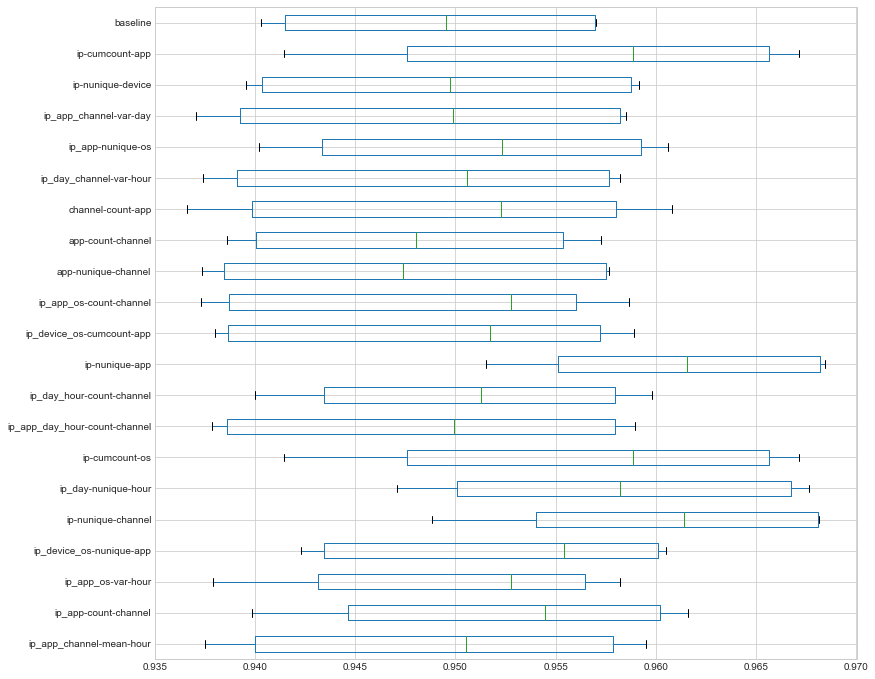

In [77]:
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(15)
df = pd.DataFrame(list(feature_gains.values()), index=list(feature_gains.keys()))
df.T.boxplot(vert=False)
plt.subplots_adjust(left=0.25)
plt.show()
fig.savefig('group-by-featurs_gain.png', dpi=200)

1. Locally I computed 10-fold cross-validation scores with 10million samples using xgBoost to see how each feature improved the model or not. The result was as follows:
    
<img src='http://i68.tinypic.com/33xkis8.png' alt="Local groupby CV tests" width='50%'/>

On the public leaderboard the score was improved from **0.955 -> 0.9584** by just including these features

# LightGBM

In [5]:
import lightgbm as lgb

def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='auc',
                      feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=10,
                      categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric': metrics,
        'learning_rate': 0.01,
        # 'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 4,
        'verbose': 0,
        'metric': metrics
    }

    lgb_params.update(params)

    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params,
                     xgtrain,
                     valid_sets=[xgtrain, xgvalid],
                     valid_names=['train', 'valid'],
                     evals_result=evals_results,
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10,
                     feval=feval)

    n_estimators = bst1.best_iteration
    print("\nModel Report")
    print("n_estimators : ", n_estimators)
    print(metrics + ":", evals_results['valid'][metrics][n_estimators - 1])

    return bst1


In [6]:
X_train = X_train.select_dtypes(include=[np.number])
valid_size = len(X_train)//10
val_df = X_train[:valid_size]
train_df = X_train[valid_size:]

In [7]:
target = 'is_attributed'
predictors = list(X_train.columns.values)
if 'is_attributed' in predictors:
    predictors.remove('is_attributed')
categorical = ['ip', 'app', 'device', 'os', 'channel']

In [9]:
boosting_types = ['gbdt']
lamdas = [0.01, 0.05, 0.1, 0.5]
max_depths = [2, 4, 8, -1]
min_child_samples_nums = [20, 40, 60, 100]
model_dict = {}

for bt in boosting_types:
    for lamda in lamdas:
        for max_depth in max_depths:
            for min_child_samples_num in min_child_samples_nums:
                print('********************************')
                model_name = bt + '_' + str(lamda) + '_' + str(max_depth) + '_' + str(min_child_samples_num)
                print('Now training model:', model_name)
                num_leaf = 2**max_depth-1 if max_depth!=-1 else 31
                params = {
                    'boosting_type': bt,
                    'reg_lambda': lamda,
                    'learning_rate': 0.1,
                    # 'is_unbalance': 'true', # replaced with scale_pos_weight argument
                    'num_leaves': num_leaf,  # 2^max_depth - 1
                    'max_depth': max_depth,  # -1 means no limit
                    'min_child_samples': min_child_samples_num,  # Minimum number of data need in a child(min_data_in_leaf)
                    'max_bin': 100,  # Number of bucketed bin for feature values
                    'subsample': 0.7,  # Subsample ratio of the training instance.
                    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
                    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
                    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
                    'scale_pos_weight': 99  # because training data is extremely unbalanced
                }

                bst = lgb_modelfit_nocv(params,
                                        train_df,
                                        val_df,
                                        predictors,
                                        target,
                                        objective='binary',
                                        metrics='auc',
                                        early_stopping_rounds=30,
                                        verbose_eval=True,
                                        num_boost_round=500,
                                        categorical_features=categorical)
                model_dict[model_name] = bst

********************************
Now training model: gbdt_0.01_2_20
preparing validation datasets


/Users/mlx/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/mlx/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.979588	valid's auc: 0.972642
[20]	train's auc: 0.991247	valid's auc: 0.99133
[30]	train's auc: 0.994664	valid's auc: 0.994674
[40]	train's auc: 0.996203	valid's auc: 0.995899
[50]	train's auc: 0.996818	valid's auc: 0.996251
[60]	train's auc: 0.997226	valid's auc: 0.996601
[70]	train's auc: 0.997548	valid's auc: 0.996862
[80]	train's auc: 0.997751	valid's auc: 0.99694
[90]	train's auc: 0.997932	valid's auc: 0.997008
[100]	train's auc: 0.998025	valid's auc: 0.997092
[110]	train's auc: 0.998136	valid's auc: 0.997108
[120]	train's auc: 0.998213	valid's auc: 0.997174
[130]	train's auc: 0.998285	valid's auc: 0.997193
[140]	train's auc: 0.998332	valid's auc: 0.997188
[150]	train's auc: 0.998386	valid's auc: 0.997234
[160]	train's auc: 0.998412	valid's auc: 0.997249
[170]	train's auc: 0.998448	valid's auc: 0.997192
[180]	train's auc: 0.998473	valid's auc: 0.997202
[190]	train's auc: 0.998506	valid's auc: 0.997191

[10]	train's auc: 0.998959	valid's auc: 0.99543
[20]	train's auc: 0.999253	valid's auc: 0.996352
[30]	train's auc: 0.999355	valid's auc: 0.995286
[40]	train's auc: 0.999429	valid's auc: 0.995124
Early stopping, best iteration is:
[19]	train's auc: 0.999238	valid's auc: 0.996753

Model Report
n_estimators :  19
auc: 0.996752924898
********************************
Now training model: gbdt_0.01_8_60
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.998945	valid's auc: 0.995133
[20]	train's auc: 0.999234	valid's auc: 0.996919
[30]	train's auc: 0.999334	valid's auc: 0.997028
[40]	train's auc: 0.999408	valid's auc: 0.996991
[50]	train's auc: 0.999463	valid's auc: 0.996823
Early stopping, best iteration is:
[29]	train's auc: 0.999326	valid's auc: 0.997084

Model Report
n_estimators :  29
auc: 0.99708430619
********************************
Now training model: gbdt_0.01_8_100
preparing validation datasets
Training until validation sc

[60]	train's auc: 0.997226	valid's auc: 0.996601
[70]	train's auc: 0.997548	valid's auc: 0.996862
[80]	train's auc: 0.997751	valid's auc: 0.99694
[90]	train's auc: 0.997932	valid's auc: 0.997008
[100]	train's auc: 0.998025	valid's auc: 0.997092
[110]	train's auc: 0.998136	valid's auc: 0.997108
[120]	train's auc: 0.998213	valid's auc: 0.997174
[130]	train's auc: 0.998285	valid's auc: 0.997193
[140]	train's auc: 0.998332	valid's auc: 0.997189
[150]	train's auc: 0.998385	valid's auc: 0.997234
[160]	train's auc: 0.998411	valid's auc: 0.997255
[170]	train's auc: 0.99846	valid's auc: 0.99724
[180]	train's auc: 0.998481	valid's auc: 0.997242
[190]	train's auc: 0.998499	valid's auc: 0.997235
[200]	train's auc: 0.998516	valid's auc: 0.997219
Early stopping, best iteration is:
[174]	train's auc: 0.998466	valid's auc: 0.997257

Model Report
n_estimators :  174
auc: 0.997257252781
********************************
Now training model: gbdt_0.05_4_20
preparing validation datasets
Training until valid

Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.979588	valid's auc: 0.972642
[20]	train's auc: 0.991247	valid's auc: 0.99133
[30]	train's auc: 0.994664	valid's auc: 0.994674
[40]	train's auc: 0.996203	valid's auc: 0.995899
[50]	train's auc: 0.996818	valid's auc: 0.996251
[60]	train's auc: 0.997226	valid's auc: 0.996601
[70]	train's auc: 0.997548	valid's auc: 0.996862
[80]	train's auc: 0.997751	valid's auc: 0.99694
[90]	train's auc: 0.997932	valid's auc: 0.997008
[100]	train's auc: 0.998006	valid's auc: 0.997062
[110]	train's auc: 0.998102	valid's auc: 0.997116
[120]	train's auc: 0.998176	valid's auc: 0.99715
[130]	train's auc: 0.998238	valid's auc: 0.997176
[140]	train's auc: 0.998282	valid's auc: 0.997185
[150]	train's auc: 0.998345	valid's auc: 0.997201
[160]	train's auc: 0.998359	valid's auc: 0.997203
[170]	train's auc: 0.99841	valid's auc: 0.997174
[180]	train's auc: 0.998448	valid's auc: 0.997212
[190]	train's auc: 0.998491	valid's auc: 0.997218
[

********************************
Now training model: gbdt_0.1_8_20
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.998981	valid's auc: 0.996948
[20]	train's auc: 0.999268	valid's auc: 0.996678
[30]	train's auc: 0.999369	valid's auc: 0.995158
Early stopping, best iteration is:
[8]	train's auc: 0.998872	valid's auc: 0.997206

Model Report
n_estimators :  8
auc: 0.997206213015
********************************
Now training model: gbdt_0.1_8_40
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.998956	valid's auc: 0.995399
[20]	train's auc: 0.999254	valid's auc: 0.996705
[30]	train's auc: 0.999357	valid's auc: 0.995348
[40]	train's auc: 0.999427	valid's auc: 0.996836
[50]	train's auc: 0.999481	valid's auc: 0.996559
Early stopping, best iteration is:
[21]	train's auc: 0.999273	valid's auc: 0.997082

Model Report
n_estimators :  21
auc: 0.997081988456
******************

[10]	train's auc: 0.979588	valid's auc: 0.972642
[20]	train's auc: 0.991247	valid's auc: 0.99133
[30]	train's auc: 0.994663	valid's auc: 0.994674
[40]	train's auc: 0.996202	valid's auc: 0.995899
[50]	train's auc: 0.996818	valid's auc: 0.996251
[60]	train's auc: 0.997226	valid's auc: 0.996601
[70]	train's auc: 0.997538	valid's auc: 0.996869
[80]	train's auc: 0.997745	valid's auc: 0.996913
[90]	train's auc: 0.997934	valid's auc: 0.997027
[100]	train's auc: 0.998045	valid's auc: 0.997138
[110]	train's auc: 0.998134	valid's auc: 0.997149
[120]	train's auc: 0.998204	valid's auc: 0.997165
[130]	train's auc: 0.998273	valid's auc: 0.997166
[140]	train's auc: 0.998315	valid's auc: 0.997184
[150]	train's auc: 0.998384	valid's auc: 0.997224
[160]	train's auc: 0.998397	valid's auc: 0.997195
[170]	train's auc: 0.998439	valid's auc: 0.997149
[180]	train's auc: 0.998467	valid's auc: 0.997179
Early stopping, best iteration is:
[154]	train's auc: 0.998393	valid's auc: 0.997238

Model Report
n_estimator

In [13]:
l = []
for model in model_dict:
    model_features = model.split('_')[1:]
    auc = model_dict[model].best_score['valid']['auc']
    l.append(model_features + [auc])


In [16]:
pd.DataFrame(l, columns)  

,0,1,2,3,4
0,gbdt,0.01,2,20,0.997256
1,gbdt,0.01,2,40,0.997256
2,gbdt,0.01,2,60,0.997256
3,gbdt,0.01,2,100,0.997256
4,gbdt,0.01,4,20,0.997293
5,gbdt,0.01,4,40,0.997277
6,gbdt,0.01,4,60,0.997245
7,gbdt,0.01,4,100,0.997187
8,gbdt,0.01,8,20,0.997214
9,gbdt,0.01,8,40,0.996753


# 2.4. Time till next click
It might be interesting to know e.g. how long it takes for a given ip-app-channel before they perform the next click. So I'll create some features for these as well. ****

In [ ]:
GROUP_BY_NEXT_CLICKS = [
    
    # V1
    {'groupby': ['ip']},
    {'groupby': ['ip', 'app']},
    {'groupby': ['ip', 'channel']},
    {'groupby': ['ip', 'os']},
    
    # V3
    {'groupby': ['ip', 'app', 'device', 'os', 'channel']},
    {'groupby': ['ip', 'os', 'device']},
    {'groupby': ['ip', 'os', 'device', 'app']}
]

# Calculate the time to next click for each group
for spec in GROUP_BY_NEXT_CLICKS:
    
    # Name of new feature
    new_feature = '{}_nextClick'.format('_'.join(spec['groupby']))    
    
    # Unique list of features to select
    all_features = spec['groupby'] + ['click_time']
    
    # Run calculation
    print(f">> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}")
    X_train[new_feature] = X_train[all_features].groupby(spec['groupby']).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds
    
X_train.head()

Locally I computed 10-fold cross-validation scores with 10million samples using xgBoost to see how each feature improved the model or not. The result was as follows:
    
<img src='http://i67.tinypic.com/2dt7y2p.png' alt="Local nextClick CV tests" width='50%'/>

On the public leaderboard the score was improved from **0.955 -> 0.9608** by just including these features

## 2.5. Clicks on app ad before & after
Has the user previously or subsequently clicked the exact same app-device-os-channel? I thought that might be an interesting feature to test out as well.

In [37]:
HISTORY_CLICKS = {
    'identical_clicks': ['ip', 'app', 'device', 'os', 'channel'],
    'app_clicks': ['ip', 'app']
}

# Go through different group-by combinations
for fname, fset in HISTORY_CLICKS.items():
    
    # Clicks in the past
    X_train['prev_'+fname] = X_train. \
        groupby(fset). \
        cumcount(). \
        rename('prev_'+fname)
        
    # Clicks in the future
    X_train['future_'+fname] = X_train.iloc[::-1]. \
        groupby(fset). \
        cumcount(). \
        rename('future_'+fname).iloc[::-1]

# Count cumulative subsequent clicks
X_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second,prev_identical_clicks,future_identical_clicks,prev_app_clicks,future_app_clicks
0,234975,2,1,13,435,2017-11-08 10:18:33,NaN,0,8,10,18,33,0,0,0,0
1,144851,2,1,19,219,2017-11-07 05:27:36,NaN,0,7,5,27,36,0,0,0,5
2,56707,6,1,10,459,2017-11-07 08:51:21,NaN,0,7,8,51,21,0,0,0,5
3,54524,3,1,19,409,2017-11-07 15:06:51,NaN,0,7,15,6,51,0,0,0,139
4,55212,9,2,12,258,2017-11-07 13:58:06,NaN,0,7,13,58,6,0,0,0,24


Locally I computed 10-fold cross-validation scores with 10million samples using xgBoost to see how each feature improved the model or not. The result was as follows:
    
<img src='http://i64.tinypic.com/2j675fr.png' alt="Local nextClick CV tests" width='50%'/>

Possibly a very small improvement. This small improvement was also seen on public LB, where the score went from **0.955 -> 0.9568** by just including these features

# 3. Evaluating Feature Importance
Having created heaps of features, I'll fit xgBoost to the data, and evaluate the feature importances. First split into X and y

In [44]:
import xgboost as xgb

# Split into X and y
y = X_train['is_attributed']
X = X_train.drop('is_attributed', axis=1).select_dtypes(include=[np.number])

# Create a model
# Params from: https://www.kaggle.com/aharless/swetha-s-xgboost-revised
clf_xgBoost = xgb.XGBClassifier(
    max_depth = 4,
    subsample = 0.8,
    colsample_bytree = 0.7,
    colsample_bylevel = 0.7,
    scale_pos_weight = 9,
    min_child_weight = 0,
    reg_alpha = 4,
    n_jobs = 4, 
    objective = 'binary:logistic'
)
# Fit the models
clf_xgBoost.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
       colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=0, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=4, reg_lambda=1, scale_pos_weight=9, seed=None,
       silent=True, subsample=0.8)

The feature importances are MinMax scaled, put into a DataFrame, and finally plotted ordered by the mean feature importance.

In [ ]:
from sklearn import preprocessing

# Get xgBoost importances
importance_dict = {}
for import_type in ['weight', 'gain', 'cover']:
    importance_dict['xgBoost-'+import_type] = clf_xgBoost.get_booster().get_score(importance_type=import_type)
    
# MinMax scale all importances
importance_df = pd.DataFrame(importance_dict).fillna(0)
importance_df = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(importance_df),
    columns=importance_df.columns,
    index=importance_df.index
)

# Create mean column
importance_df['mean'] = importance_df.mean(axis=1)

# Plot the feature importances
importance_df.sort_values('mean').plot(kind='bar', figsize=(20, 7))

# Evaluation on Public Leaderboard
I've evaluated the impact of all the above features on the public leaderboard - the results are as follows for the simple xgBoost model used in this notebook applyed to the entire training set, without any additional tuning etc.

<img src='http://i63.tinypic.com/jjtpow.png' width='50%' />

In [27]:
X_test['is_attributed'] = model_dict['gbdt_0.01_8_100'].predict(X_test[predictors])

In [28]:
X_test[['click_id', 'is_attributed']].to_csv('/Users/mlx/Downloads/Document/talking_data/gbdt_40features.csv', index=False)